In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [39]:
df = pd.read_csv("TCS.NS.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()

In [40]:
atributes = list(df)[1:6]
df_for_training = df[atributes].astype(float)

In [41]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [42]:
trainX = []
trainY = []

n_past = 100
n_future = 1

In [43]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 4])

In [44]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('Dataframe shape == {}.'.format(df.shape))

trainX shape == (5287, 100, 5).
trainY shape == (5287, 1).
Dataframe shape == (5387, 7).


In [45]:
dates = df["Date"][n_past:]
dates = dates.to_numpy()
dates.shape

(5287,)

In [46]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], trainX[:q_80], trainY[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], trainX[q_80:q_90], trainY[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], trainX[q_90:], trainY[q_90:]

In [47]:
model = Sequential()
model.add(LSTM(50,input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(trainY.shape[1]))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 100, 50)             │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,651 (201.76 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:

cp1 = ModelCheckpoint('model/stock.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
callbacks_list = [cp1, earlystop]
model.compile(loss='mse',optimizer=Adam(learning_rate=0.001),metrics=['mean_absolute_error'])

In [50]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,callbacks=callbacks_list)

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0292 - mean_absolute_error: 0.0941 - val_loss: 0.2375 - val_mean_absolute_error: 0.3905
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error
  current = self.get_monitor_value(logs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0010 - mean_absolute_error: 0.0208 - val_loss: 0.2453 - val_mean_absolute_error: 0.3995
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 9.4699e-04 - mean_absolute_error: 0.0202 - val_loss: 0.2297 - val_mean_absolute_error: 0.3831
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.2799e-04 - mean_absolute_error: 0.0200 - val_loss: 0.2442 - val_mean_absolute_error: 0.4042
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 9.5722e-04 - mean_absolute_error: 0.0204 - val_loss: 0.2342 - val_mean_absolute_error: 0.3944
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 8.3999e-04 - mean_absolute_error: 0.0186 - val_loss: 0.2616 - val_mean_absolute_error: 0.4256
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 8.8955e-04 - mean_absolute_error: 0.0192 - val_loss: 0.1907 - val_mean_absolute_error: 0.3490
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.7759e-04 - mean_

In [52]:
model = load_model('model/stock.keras')

ValueError: File not found: filepath=model/stock.keras. Please ensure the file is an accessible `.keras` zip file.

In [54]:
model.save('TCS_Stock_Market_Model.keras')

In [55]:
ytr = np.repeat(y_train, df_for_training.shape[1], axis=-1)
y_train_rvsc = scaler.inverse_transform(ytr)[:,4]

In [56]:
yv = np.repeat(y_val, df_for_training.shape[1], axis=-1)
y_val_rvsc = scaler.inverse_transform(yv)[:,4]

In [57]:
yt = np.repeat(y_test, df_for_training.shape[1], axis=-1)
y_test_rvsc = scaler.inverse_transform(yt)[:,4]

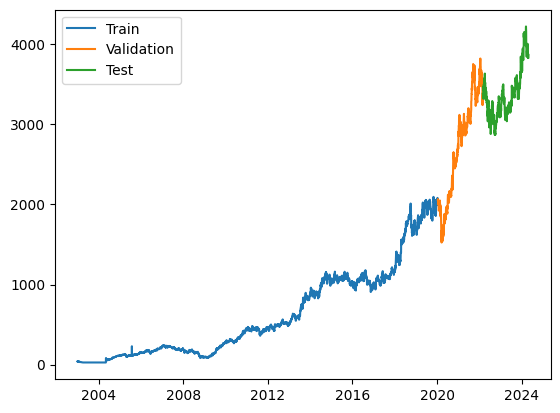

In [58]:

plt.plot(dates_train, y_train_rvsc)
plt.plot(dates_val, y_val_rvsc)
plt.plot(dates_test, y_test_rvsc)

plt.legend(['Train', 'Validation', 'Test'])

In [59]:
train_predictions = model.predict(X_train).flatten().reshape(-1,1)

133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [60]:
trp = np.repeat(train_predictions, df_for_training.shape[1], axis=-1)
train_predictions_rvsc = scaler.inverse_transform(trp)[:,4]

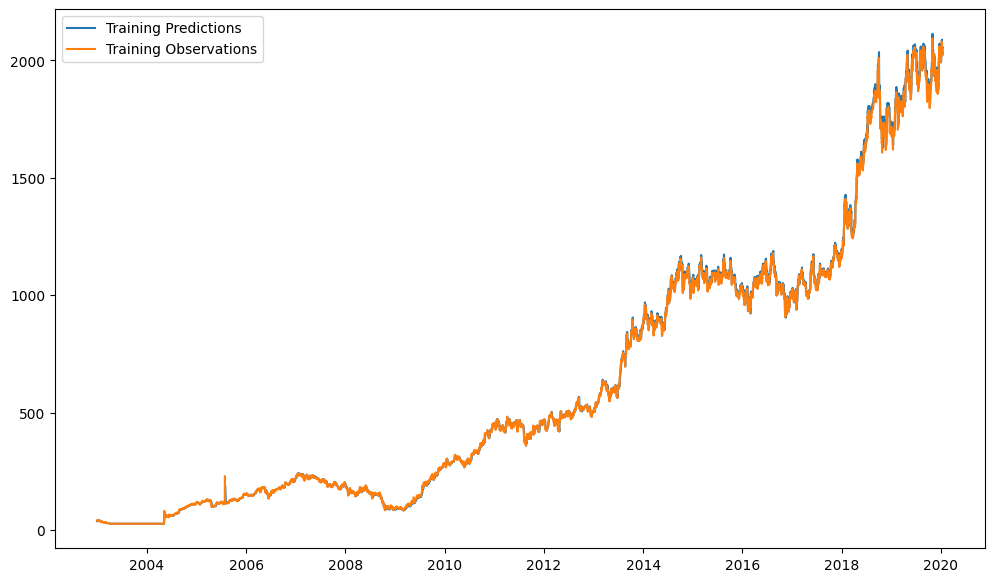

In [61]:
plt.figure(figsize=(12, 7))
plt.plot(dates_train, train_predictions_rvsc)
plt.plot(dates_train, y_train_rvsc)
plt.legend(['Training Predictions', 'Training Observations'])

In [62]:
val_predictions = model.predict(X_val).flatten().reshape(-1,1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [63]:
tval = np.repeat(val_predictions, df_for_training.shape[1], axis=-1)
val_predictions_rvsc = scaler.inverse_transform(tval)[:,4]

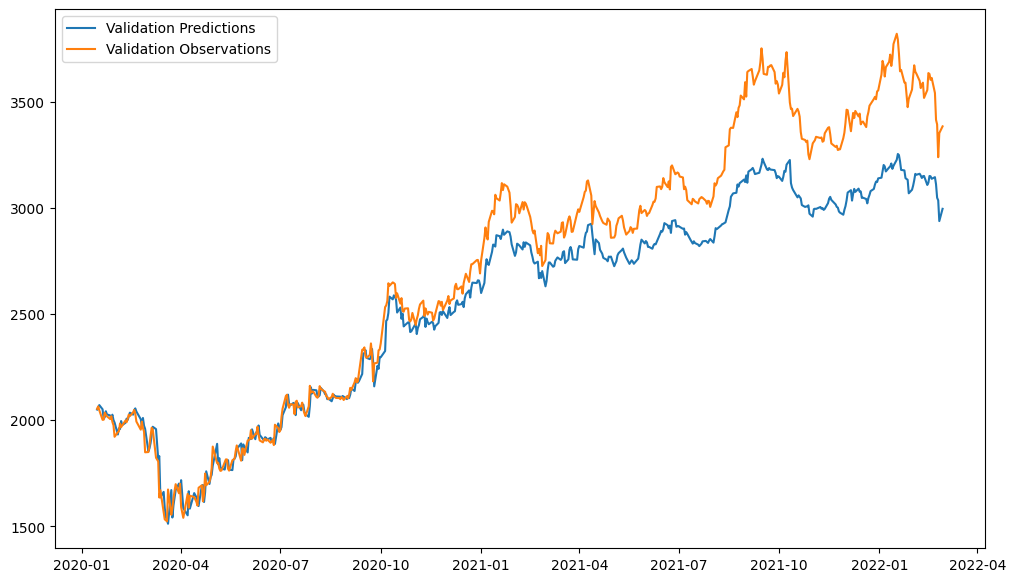

In [64]:
plt.figure(figsize=(12, 7))
plt.plot(dates_val, val_predictions_rvsc)
plt.plot(dates_val, y_val_rvsc)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [65]:
test_predictions = model.predict(X_test).flatten().reshape(-1,1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [66]:
ttest = np.repeat(test_predictions, df_for_training.shape[1], axis=-1)
test_predictions_rvsc = scaler.inverse_transform(ttest)[:,4]

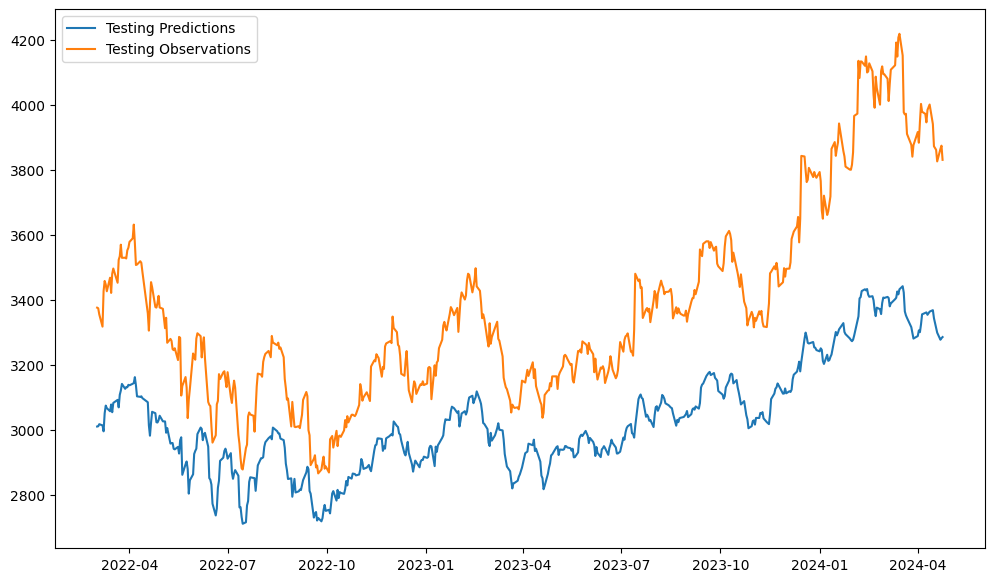

In [67]:
plt.figure(figsize=(12, 7))
plt.plot(dates_test, test_predictions_rvsc)
plt.plot(dates_test, y_test_rvsc)
plt.legend(['Testing Predictions', 'Testing Observations'])

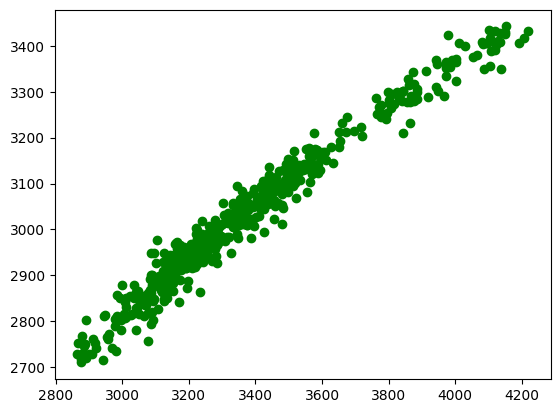

In [68]:
plt.scatter(y_test_rvsc,test_predictions_rvsc, color = "g")